In [2]:
# Standard library imports
import os
import sys
import re
import itertools
import glob
import pickle
import zipfile

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mpmath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
from scipy import stats, optimize as opt, signal
from scipy.special import hyp2f1
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import (
    ScalarFormatter, LogLocator, LogFormatterMathtext, LogFormatter,
    AutoMinorLocator, MultipleLocator, NullFormatter
)
from matplotlib.markers import MarkerStyle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Figure and plotting settings
fig_formats = ['.pdf', '.eps', '.tiff', '.png']
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden * 8 * cms, 8 * cms)
figsizes = {
    "1 column": (3.43, 3.43 / golden),
    "1.5 columns": (4.49, 4.49 / golden),
    "2 columns": (7.01, 7.01 / golden)
}

# Color palettes
light_palette = ['#504B43', '#4caf50', '#948d99']
dark_palette = ['#285DB1', '#AC3127', '#c1bbb0']
color_clusters = ['#648fff', '#ffb000', '#948d99']
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB
metacolor = {'metaT': metaTcolor, 'metaG': metaGcolor, 'metaB': metaBcolor}
metamarker = {'metaT': 'o', 'metaG': 'd', 'metaB': 's'}
palettename = 'coolwarm'
palette_temp = sns.color_palette(palettename, 32)

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Seaborn and matplotlib settings
sns.set_theme(
    rc={
        'figure.figsize': figsizes["2 columns"],
        'figure.dpi': 200,
        'savefig.dpi': 300
    },
    font="Helvetica Neue",
    font_scale=1.3,
    style="ticks"
)

plt.rcParams.update({
    'legend.edgecolor': 'k',
    'legend.facecolor': 'w',
    'legend.frameon': True,
    'legend.framealpha': 1,
    'legend.fancybox': False,
    'legend.fontsize': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'k',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 14,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"\usepackage{amsmath, helvet} \renewcommand{\familydefault}{\sfdefault}"
})

# Jupyter autoreload magic
%reload_ext autoreload
%autoreload 1

In [3]:
def log_hist(data, nbins=30):    
    data_positive = data[data > 0]
    bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), nbins)
    counts = np.histogram(data_positive, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    return bins, counts, prob, pdf

def return_color_station(station, metadata, palette_temp=palette_temp):
    # if station is a string convert to integer
    if isinstance(station, str):
        station = int(station)
    temperature = int(metadata.loc[station, 'temp_woa'])+1
    return palette_temp[temperature]

def plot_logSAD(data, nbins=20):
    bins, counts, prob, pdf = log_hist(data, nbins=nbins)
    xx = np.sqrt(bins[:-1]*bins[1:])
    yy = pdf
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def plot_logrescaledSAD(data, nbins=20):
    data = data[data>0]
    y = np.log(data)
    z = (y-np.mean(y))/np.std(y)
    hist, bins = np.histogram(z, bins=nbins, density=True)
    xx = (bins[1:] + bins[:-1])/2
    yy = hist
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def paretoDistribution(x, k, a, c, mu):
    if x >= mu:
        pdf = (k**(-1/c) * a * (1 + ((x - mu)/k)**(1/c))**(-1 - a) * (x - mu)**(-1 + 1/c)) / c
    else:
        pdf = 0
    return pdf

In [4]:
metadata = pd.read_csv('../data/environment/woa_pisces_tarassd2.tsv', index_col=0, sep='\t')
metadata.index = metadata.index.astype(int)
metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="ESRI:54030")

metadata['temp_category'] = pd.cut(metadata.temp_woa, bins=[-np.inf, 15, np.inf], labels=['low', 'high'])
metadata['inverseTemperature'] = 1000/(metadata['temp_woa']+273.15)
metadata['color'] = metadata.index.map(lambda x: return_color_station(x, metadata))

In [5]:
metaT = pd.read_csv(f'../data/metaT_micro_bacilla.csv', index_col=0)
metaG = pd.read_csv(f'../data/metaG_micro_bacilla.csv', index_col=0)
metaT.columns = metaT.columns.astype(int)
metaG.columns = metaG.columns.astype(int)
# /Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/data/Abundance.csv
#metaB = pd.read_csv(f'{directory}/metaB_micro/Abundances_C.csv', index_col=0)

df_meta = {'metaT': metaT, 'metaG': metaG}
df_meta_relative = {key: df.div(df.sum(axis=0), axis=1) for key, df in df_meta.items()}

del metaT, metaG


In [6]:
filename = '../fit/summary_fit_metaT_micro_bacilla.csv'
fit_metaT = pd.read_csv(filename, index_col=0)
filename = '../fit/summary_fit_metaG_micro_bacilla.csv'
fit_metaG = pd.read_csv(filename, index_col=0)
#fit_metaT['k_cum_model'] = np.maximum(10**fit_metaT['logk_cum'] - fit_metaT['mu_cum'], fit_metaT['mu_cum'])
fit_metaT['k_KS_model'] = np.maximum(10**fit_metaT['logk'] - fit_metaT['mu_KS'], fit_metaT['mu_KS'])
#fit_metaG['k_cum_model'] = np.maximum(10**fit_metaG['logk_cum'] - fit_metaG['mu_cum'], fit_metaG['mu_cum'])
fit_metaG['k_KS_model'] = np.maximum(10**fit_metaG['logk'] - fit_metaG['mu_KS'], fit_metaG['mu_KS'])

df_fits = {'metaT': fit_metaT, 'metaG': fit_metaG}

for meta in ['metaT', 'metaG']: 
    df_fits[meta]['N_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).sum() for station in df_meta[meta].columns}
    df_fits[meta]['S_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).astype(bool).sum() for station in df_meta[meta].columns}
    df_fits[meta]['mean_n_filtered'] = df_fits[meta]['N_filtered']/df_fits[meta]['S_filtered']
    df_fits[meta]['n_max'] = {station: df_meta[meta][station].max() for station in df_meta[meta].columns}
    df_fits[meta]['fitted_decades'] = np.log10(df_fits[meta]['n_max']) - np.log10(df_fits[meta]['mu_KS'])

In [7]:
gdf = metadata.copy()
gdf['mean_metaT'] = df_meta['metaT'].sum(axis=0)/df_meta['metaT'].astype(bool).sum(axis=0)
gdf['mean_metaG'] = df_meta['metaG'].sum(axis=0)/df_meta['metaG'].astype(bool).sum(axis=0)
gdf['total_metaT'] = df_meta['metaT'].sum(axis=0)
gdf['total_metaG'] = df_meta['metaG'].sum(axis=0)
gdf['mu_metaT'] = df_fits['metaT']['mu_KS']
gdf['mu_metaG'] = df_fits['metaG']['mu_KS']
gdf['alpha_metaT'] = df_fits['metaT']['alpha']
gdf['alpha_metaG'] = df_fits['metaG']['alpha']
gdf['k_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)

gdf['alpha_sup_metaT'] = df_fits['metaT']['alpha_high']
gdf['alpha_sup_metaG'] = df_fits['metaG']['alpha_high']
gdf['alpha_inf_metaT'] = df_fits['metaT']['alpha_low']
gdf['alpha_inf_metaG'] = df_fits['metaG']['alpha_low']

gdf['inverseTemperature'] = 1000/(gdf['temp_woa']+273.15)
gdf['kT/kG'] = gdf['k_metaT']/gdf['k_metaG']

# filter gdf only to stations where k_metaG is non nan
gdf = gdf[gdf['k_metaG'].notna()]

In [8]:
N_metaT = df_meta['metaT'].sum(axis=0)
S_metaT = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0)
N_metaG = df_meta['metaG'].sum(axis=0)
S_metaG = df_meta['metaG'].fillna(0).astype(bool).sum(axis=0)

# Figures S2-S6

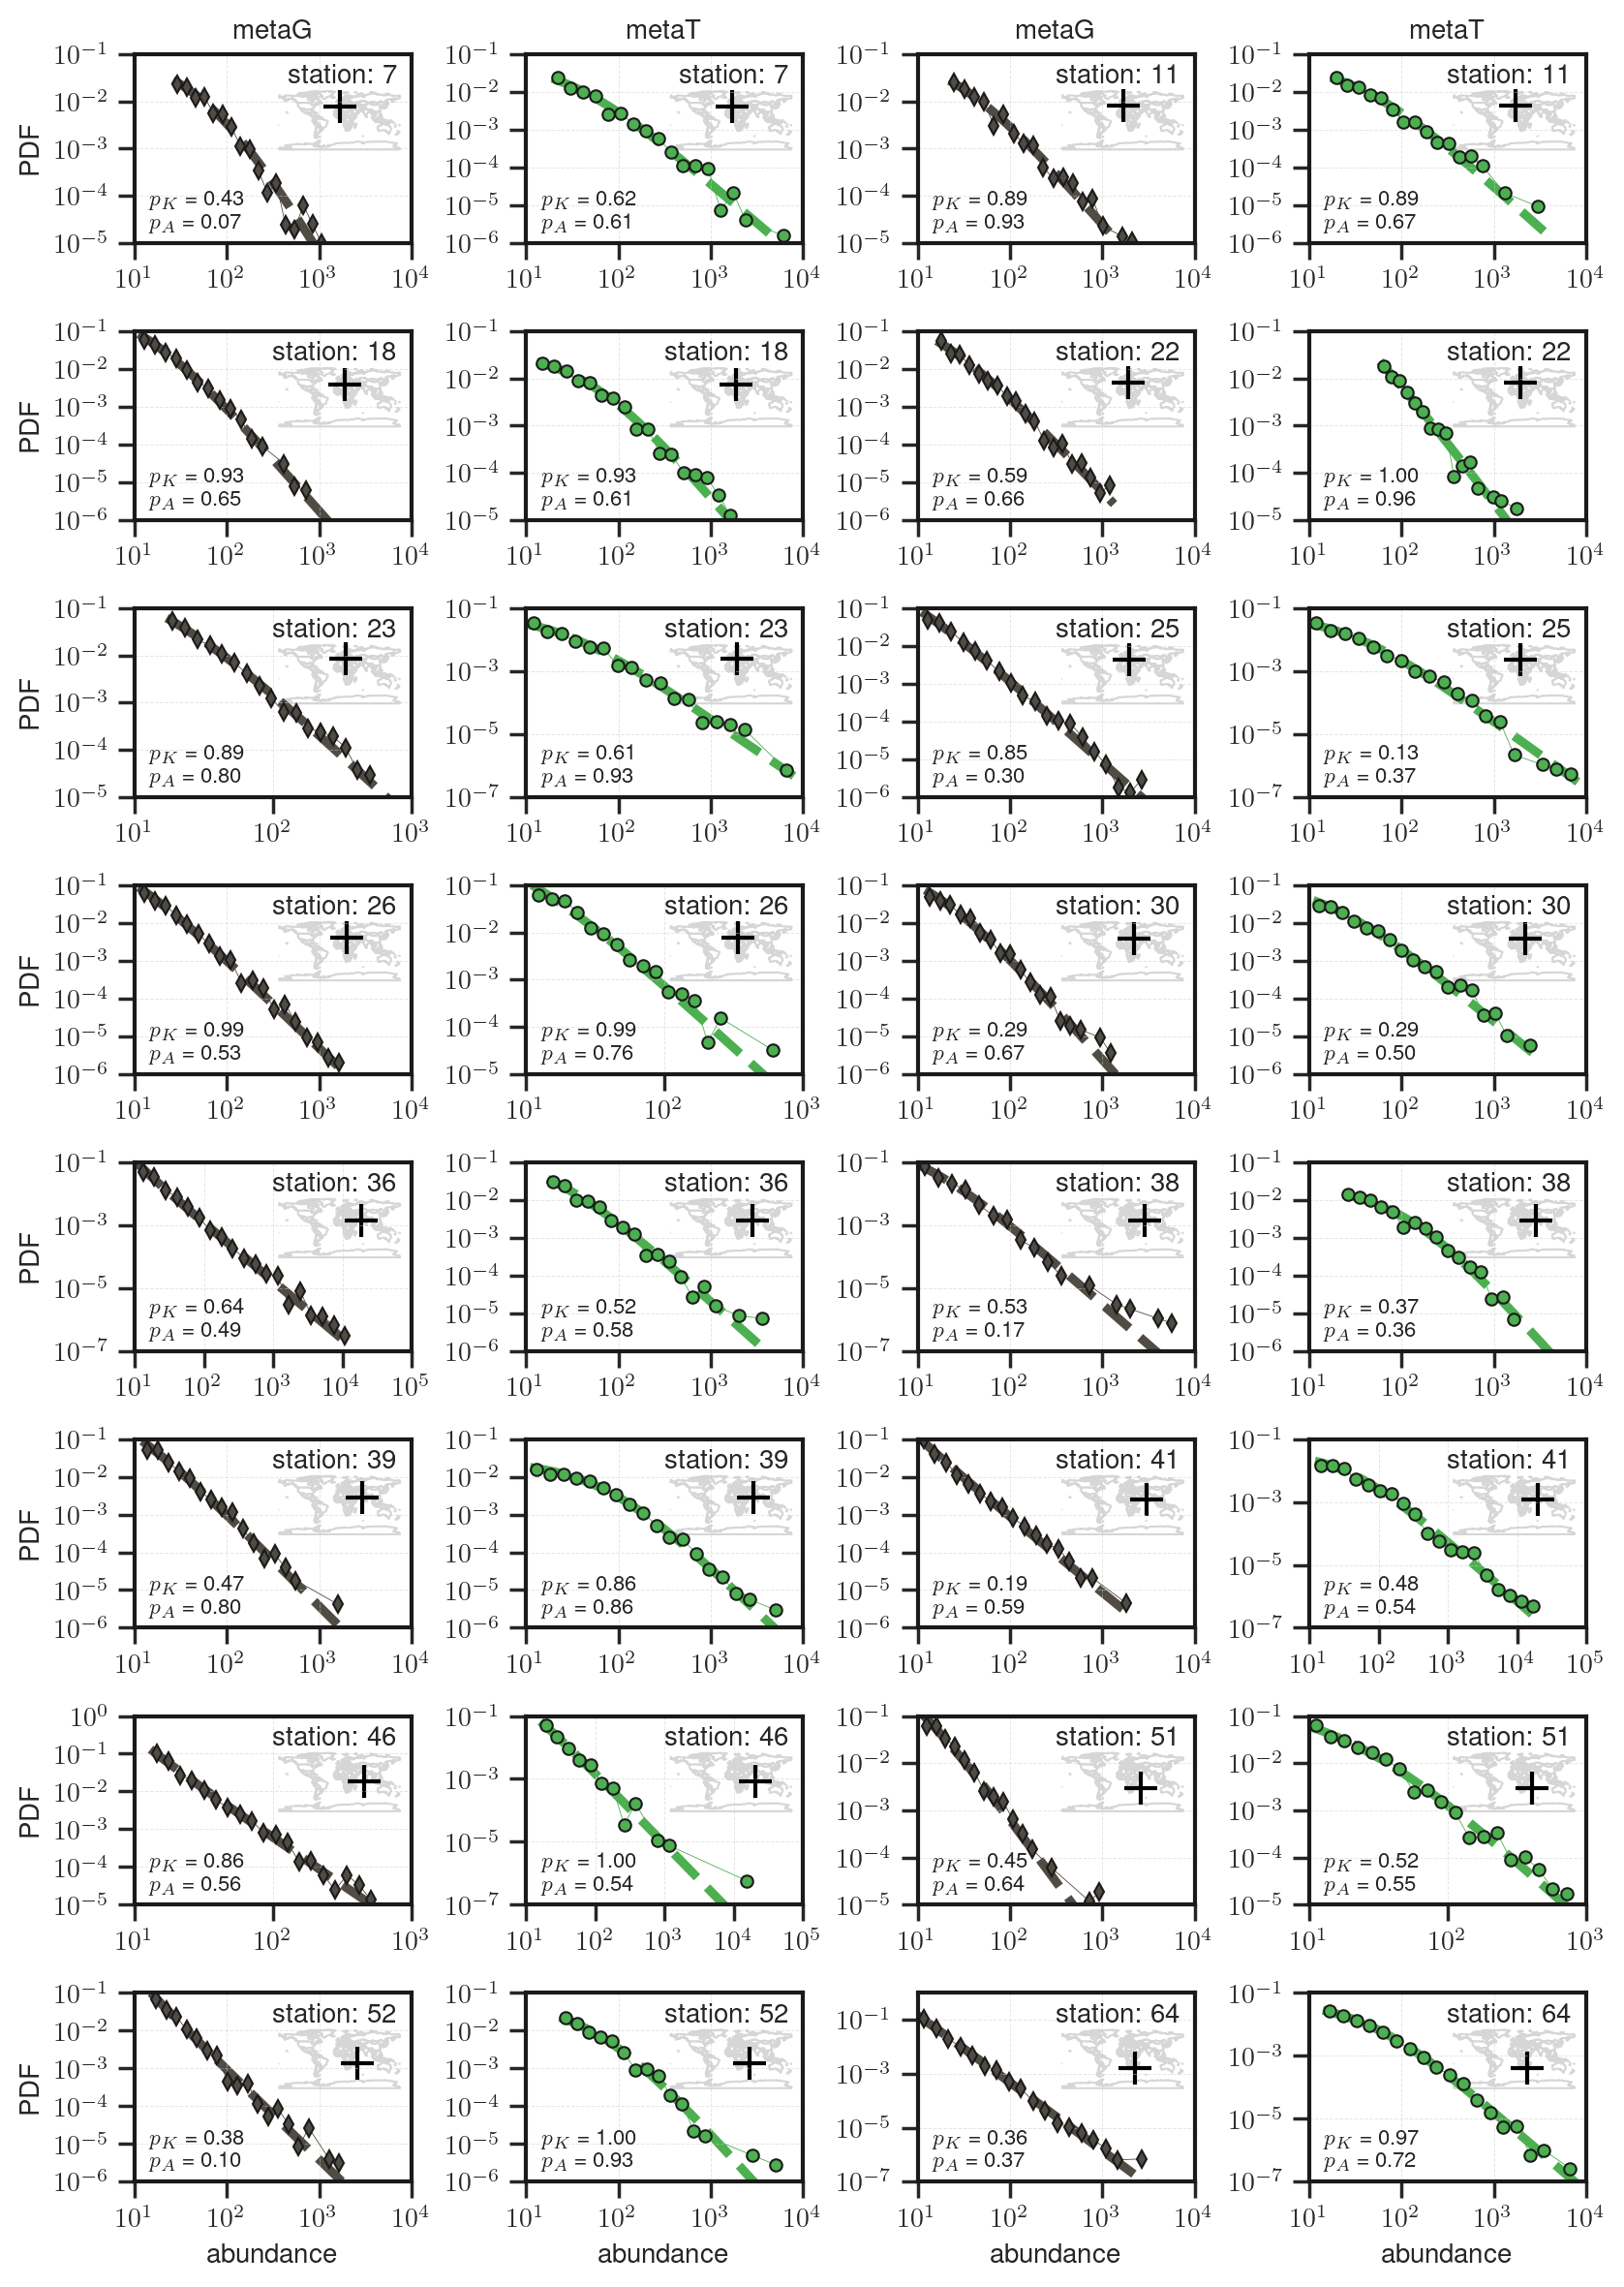

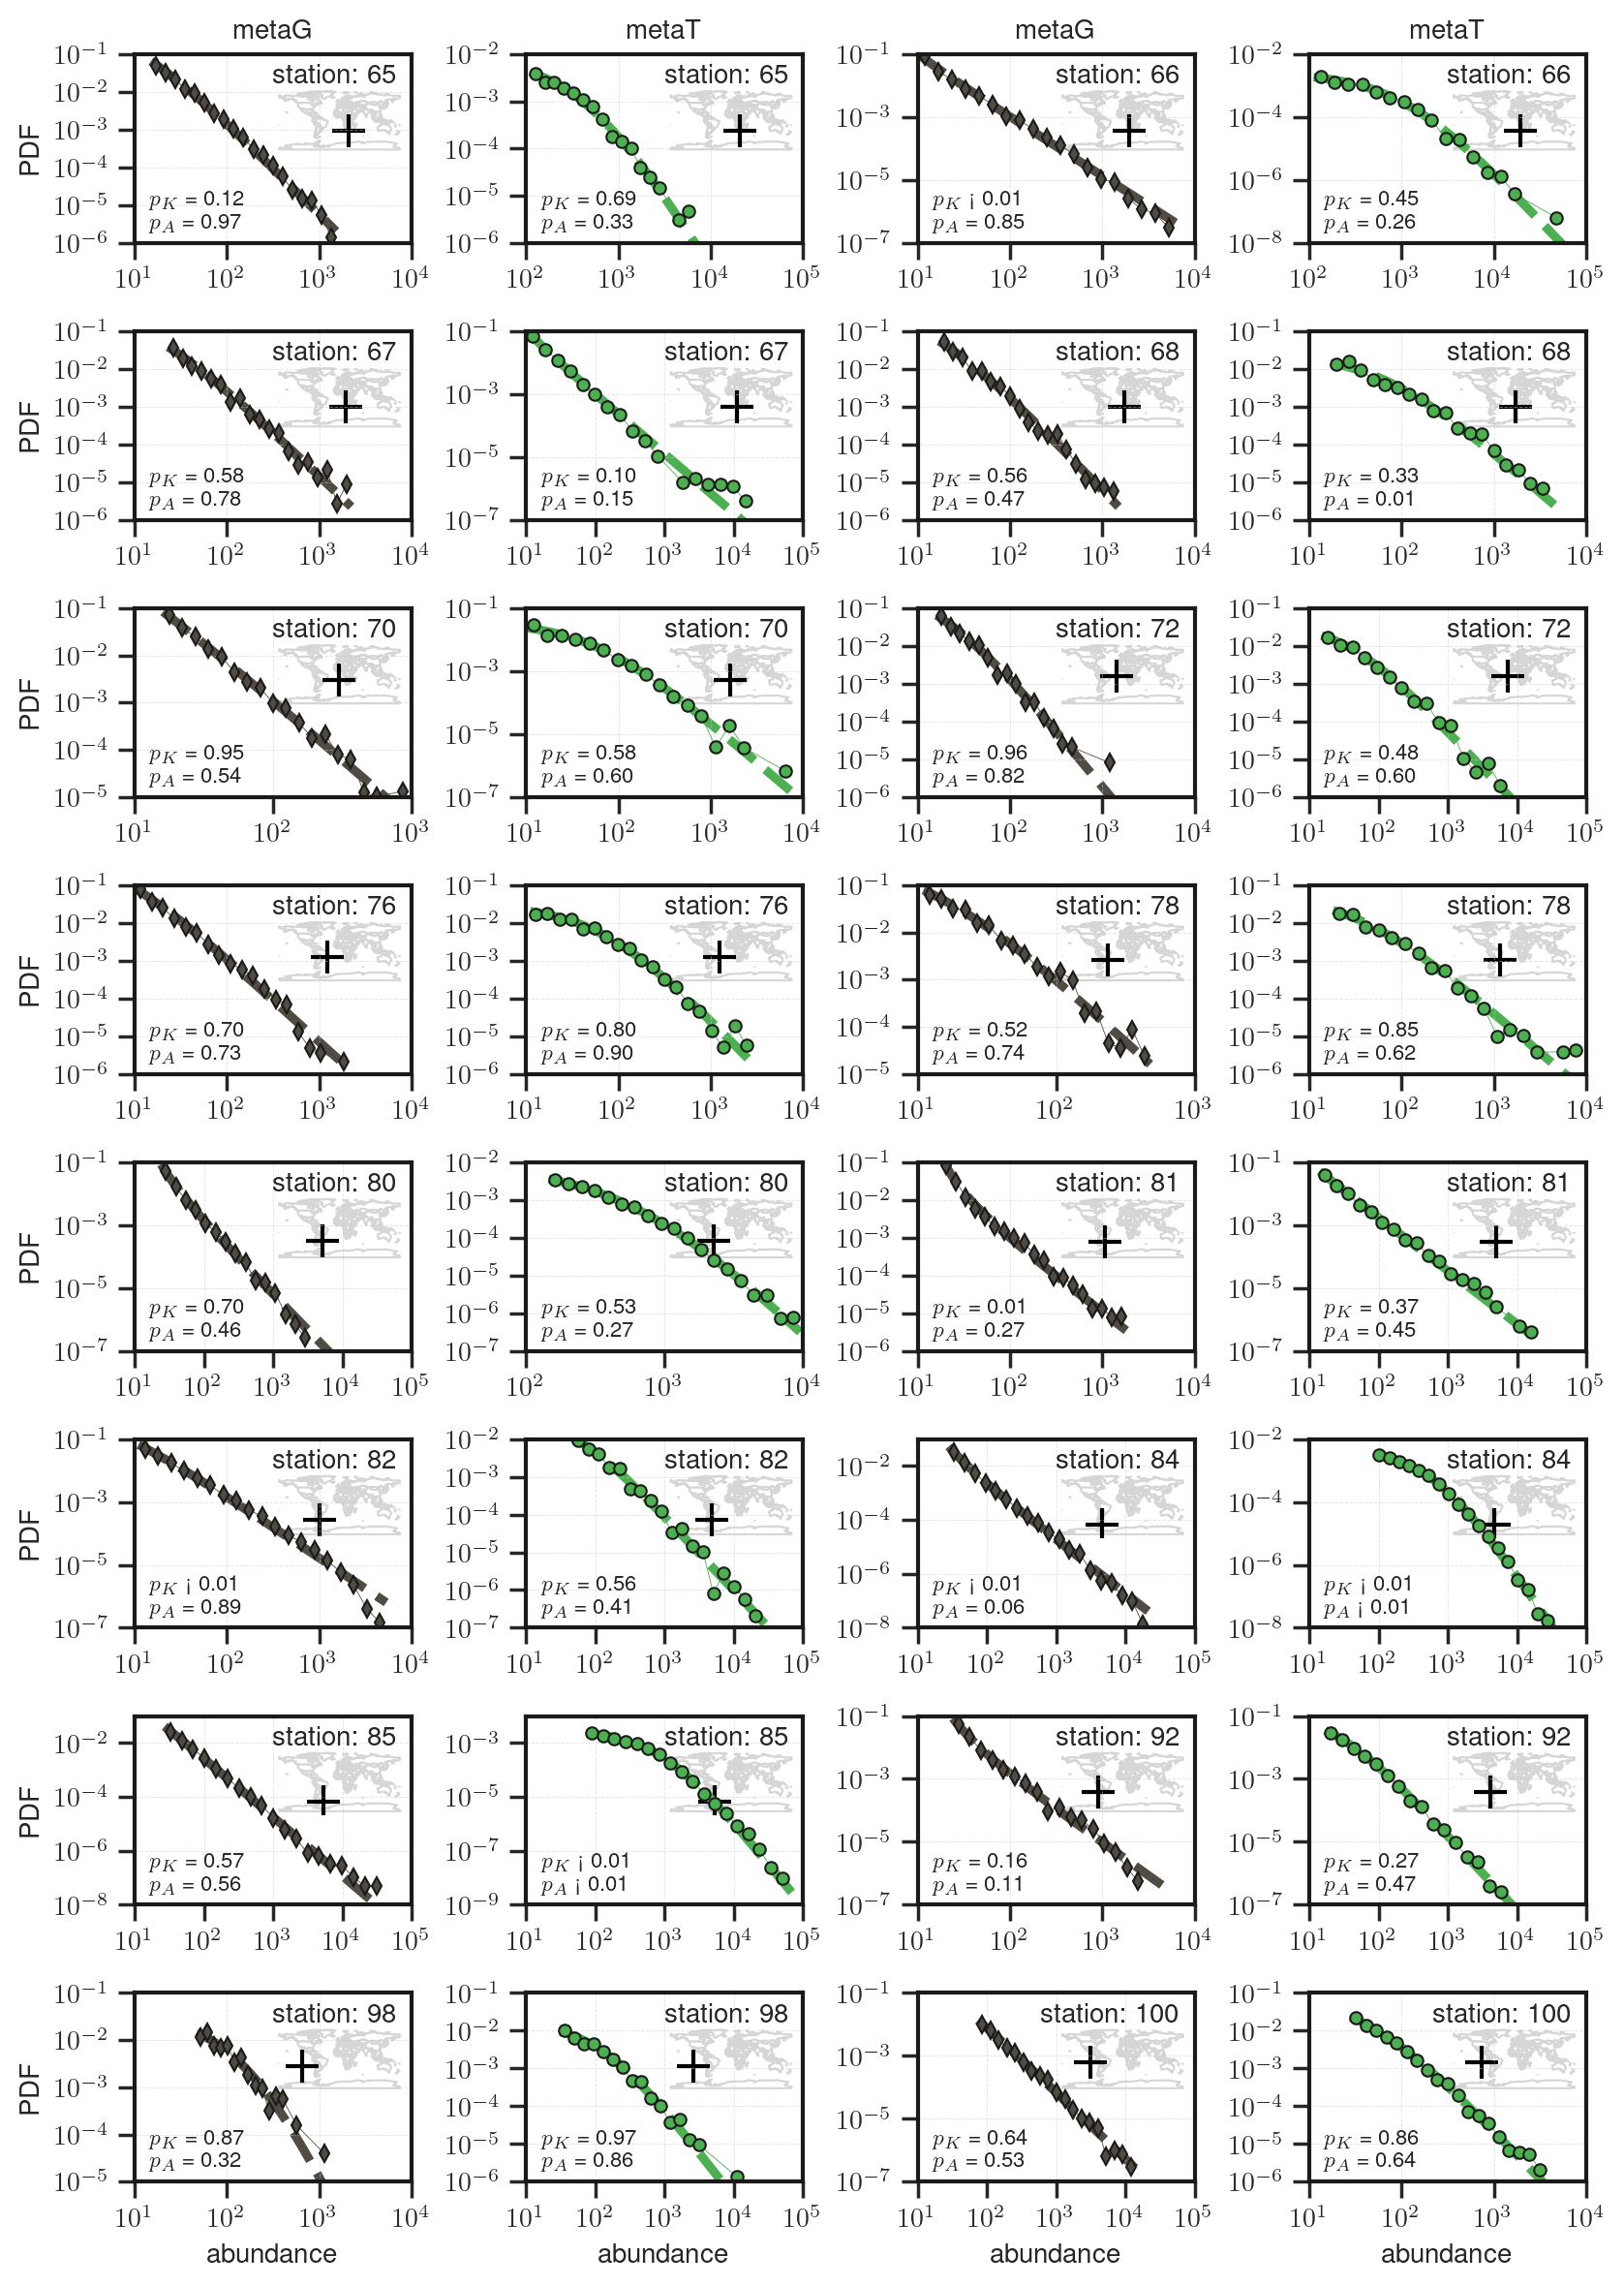

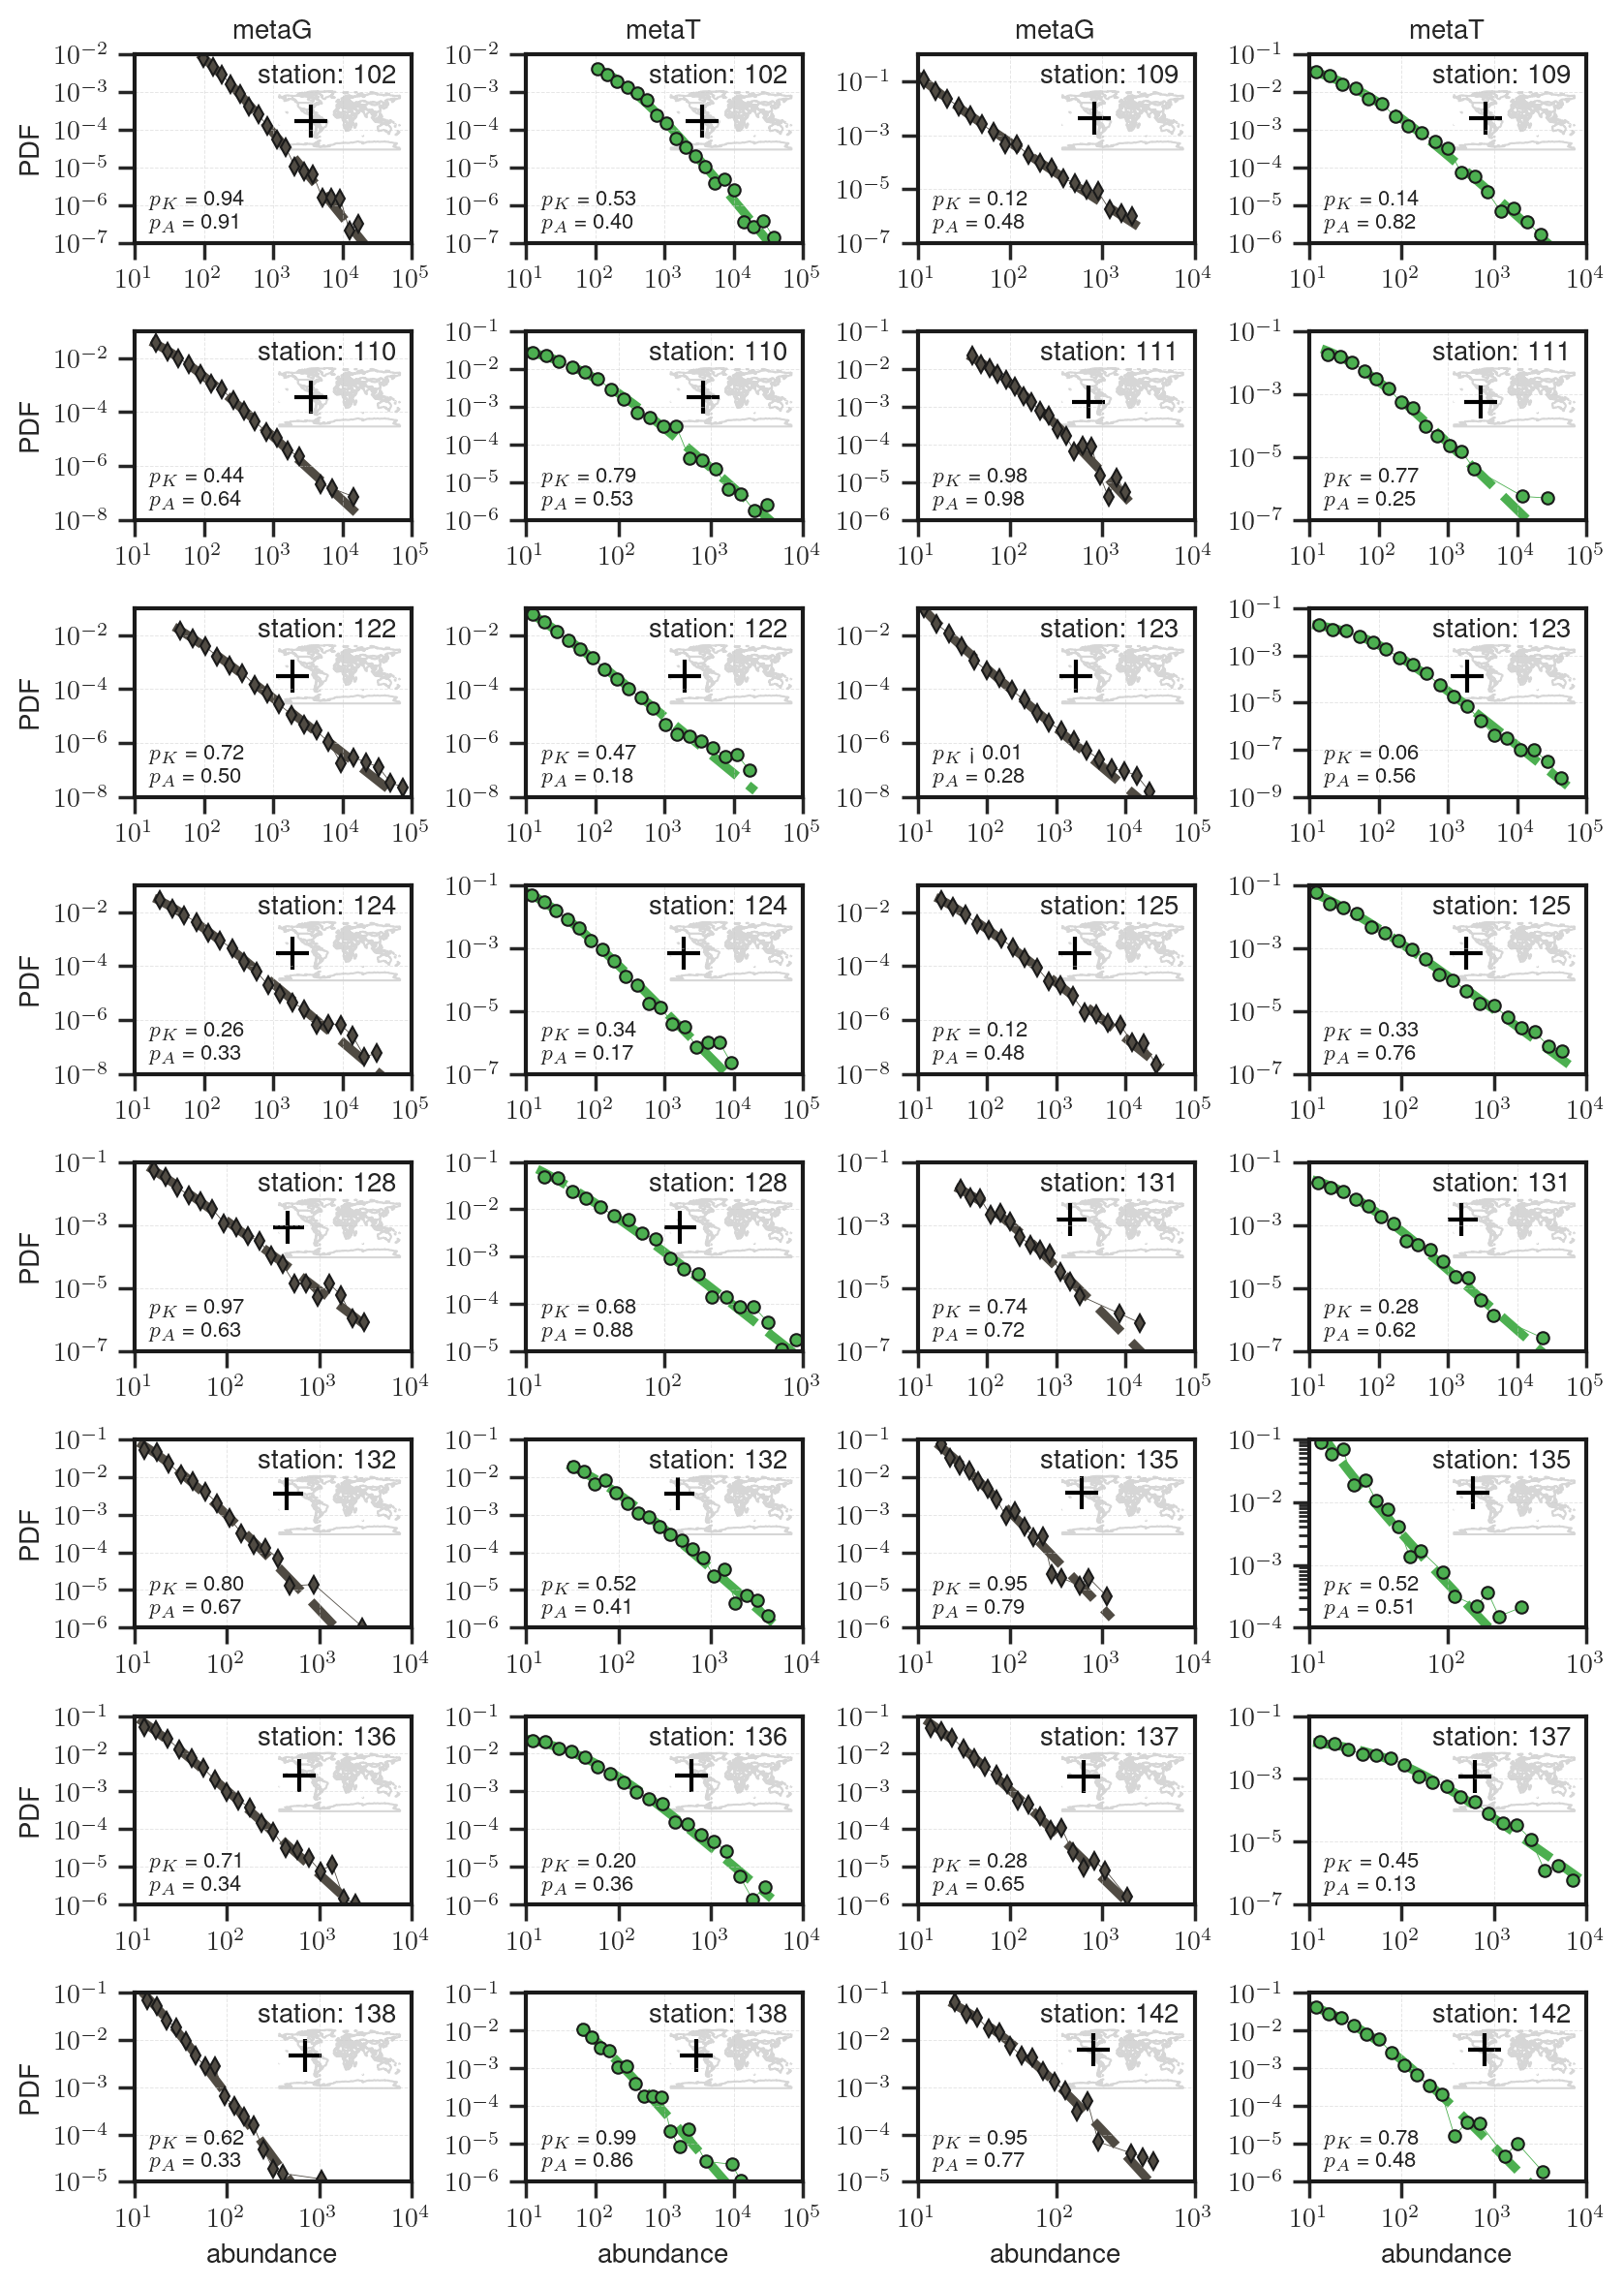

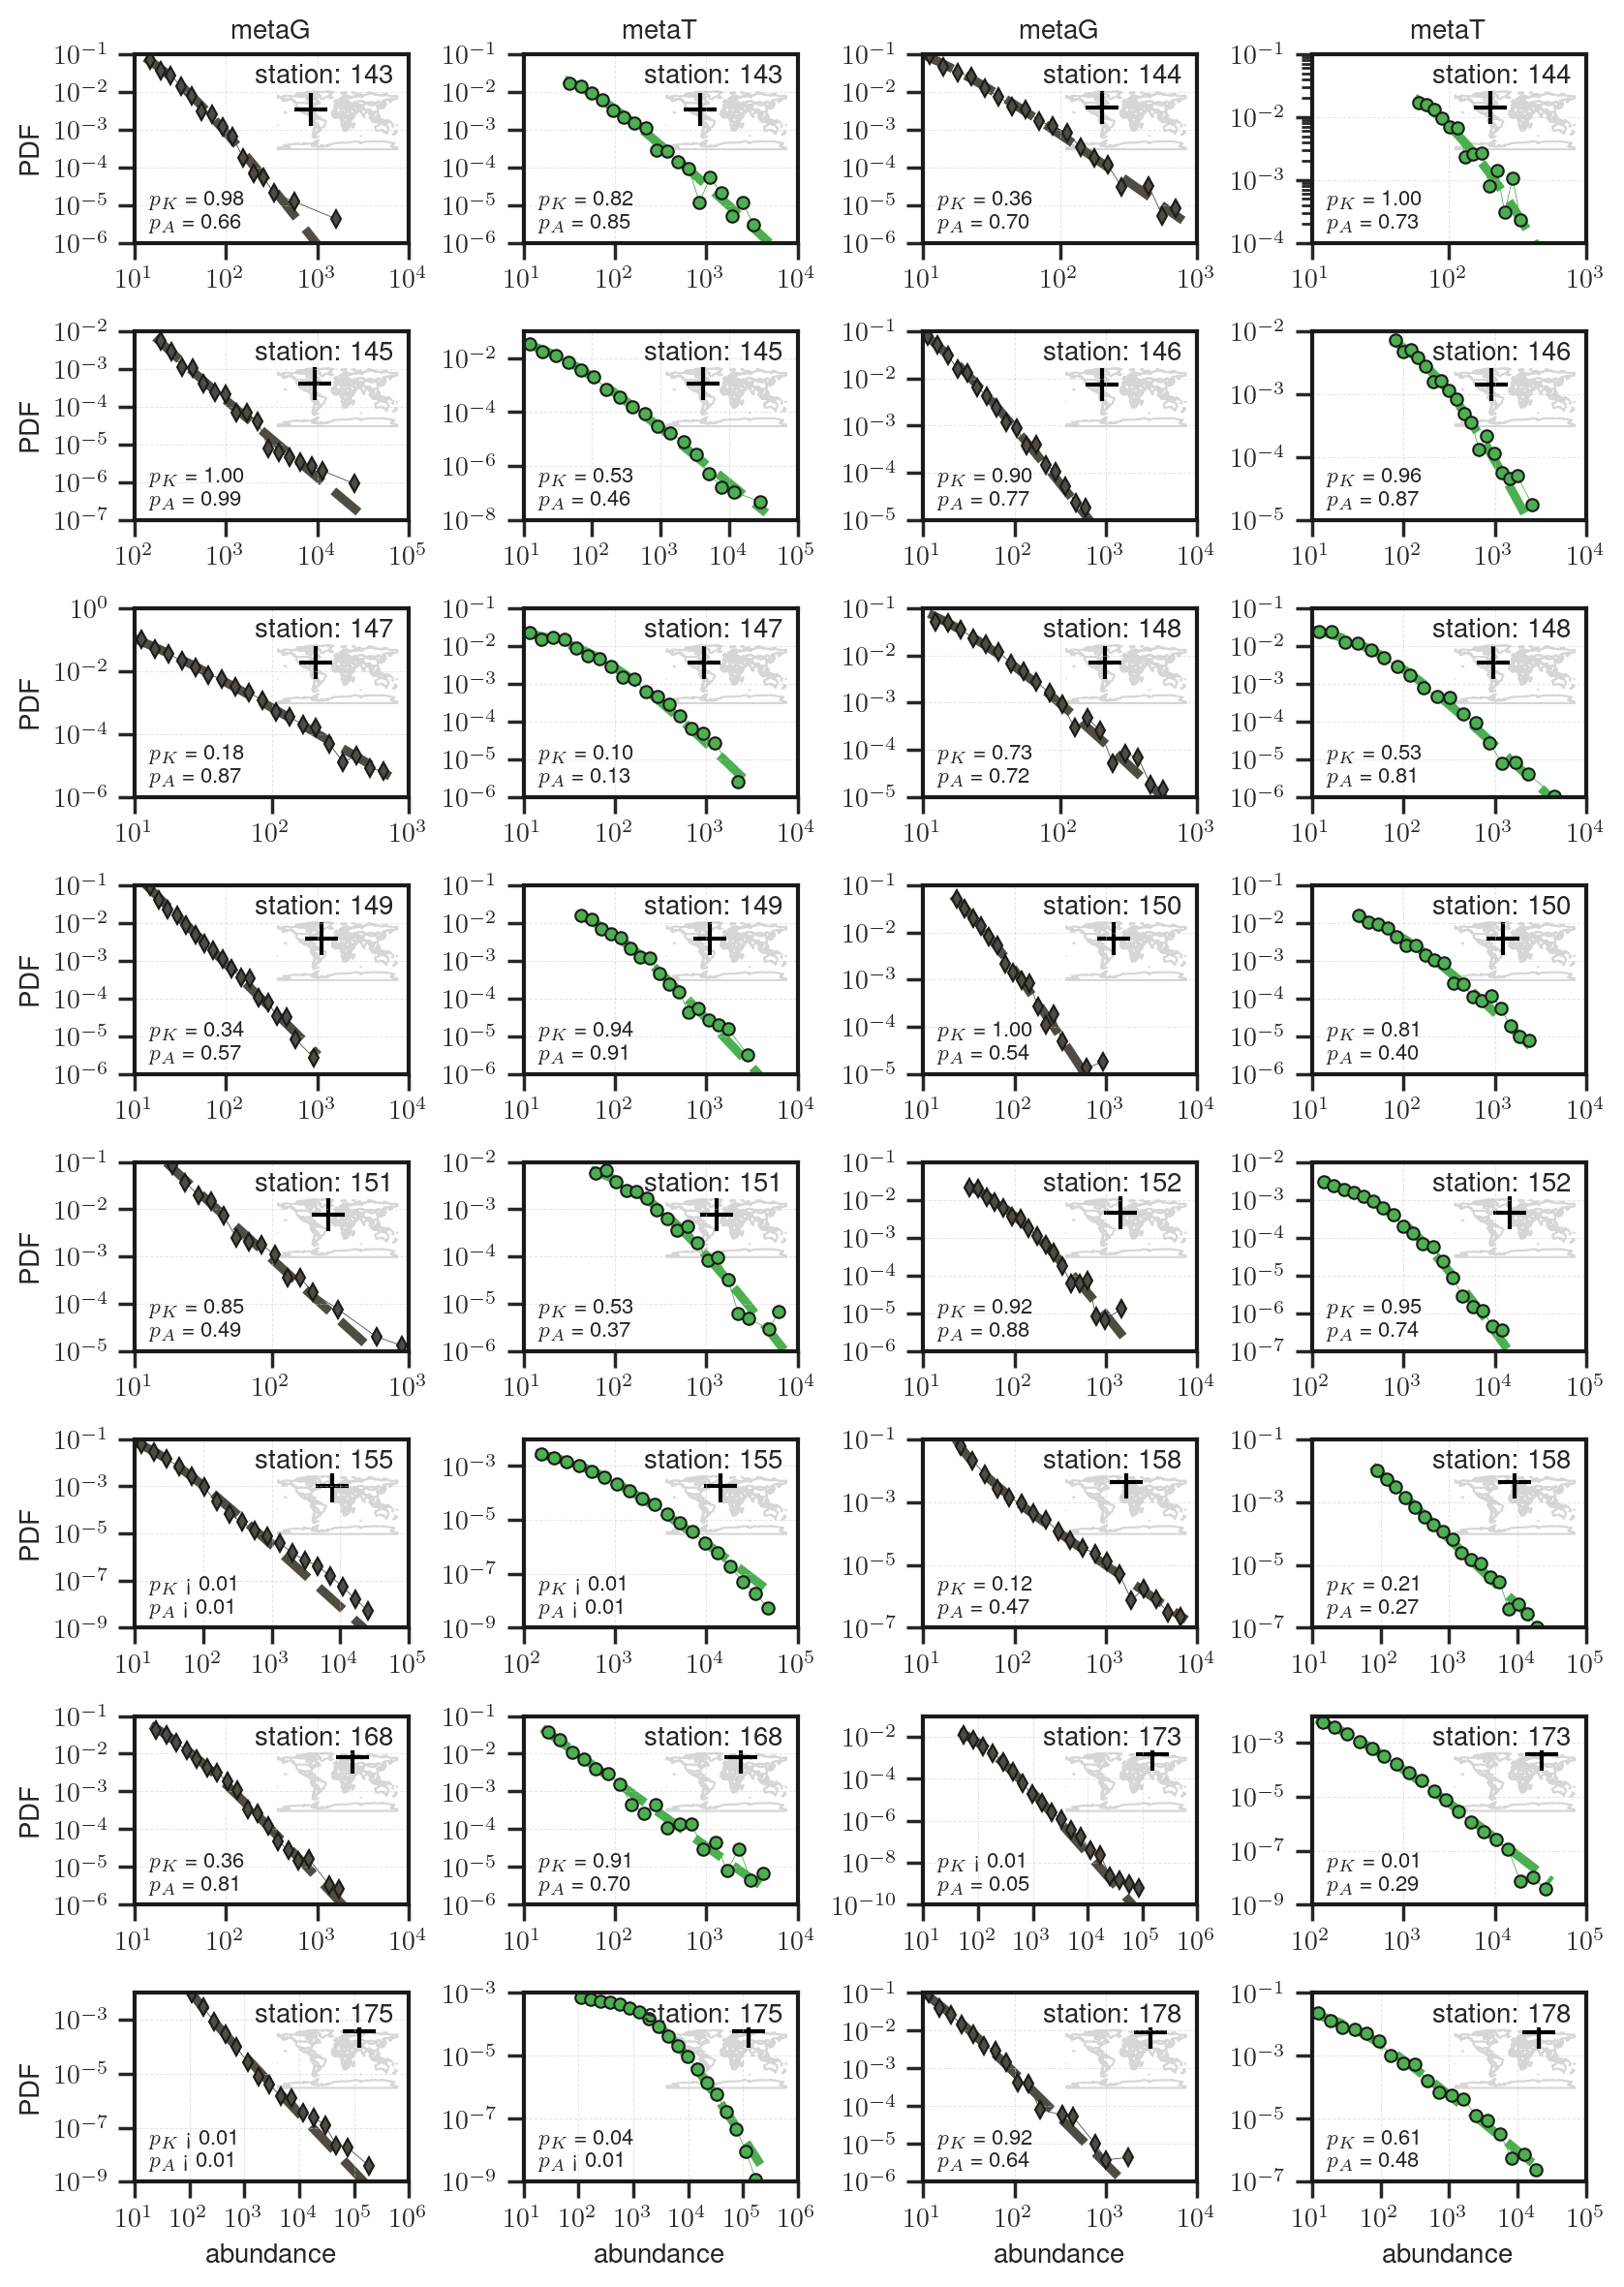

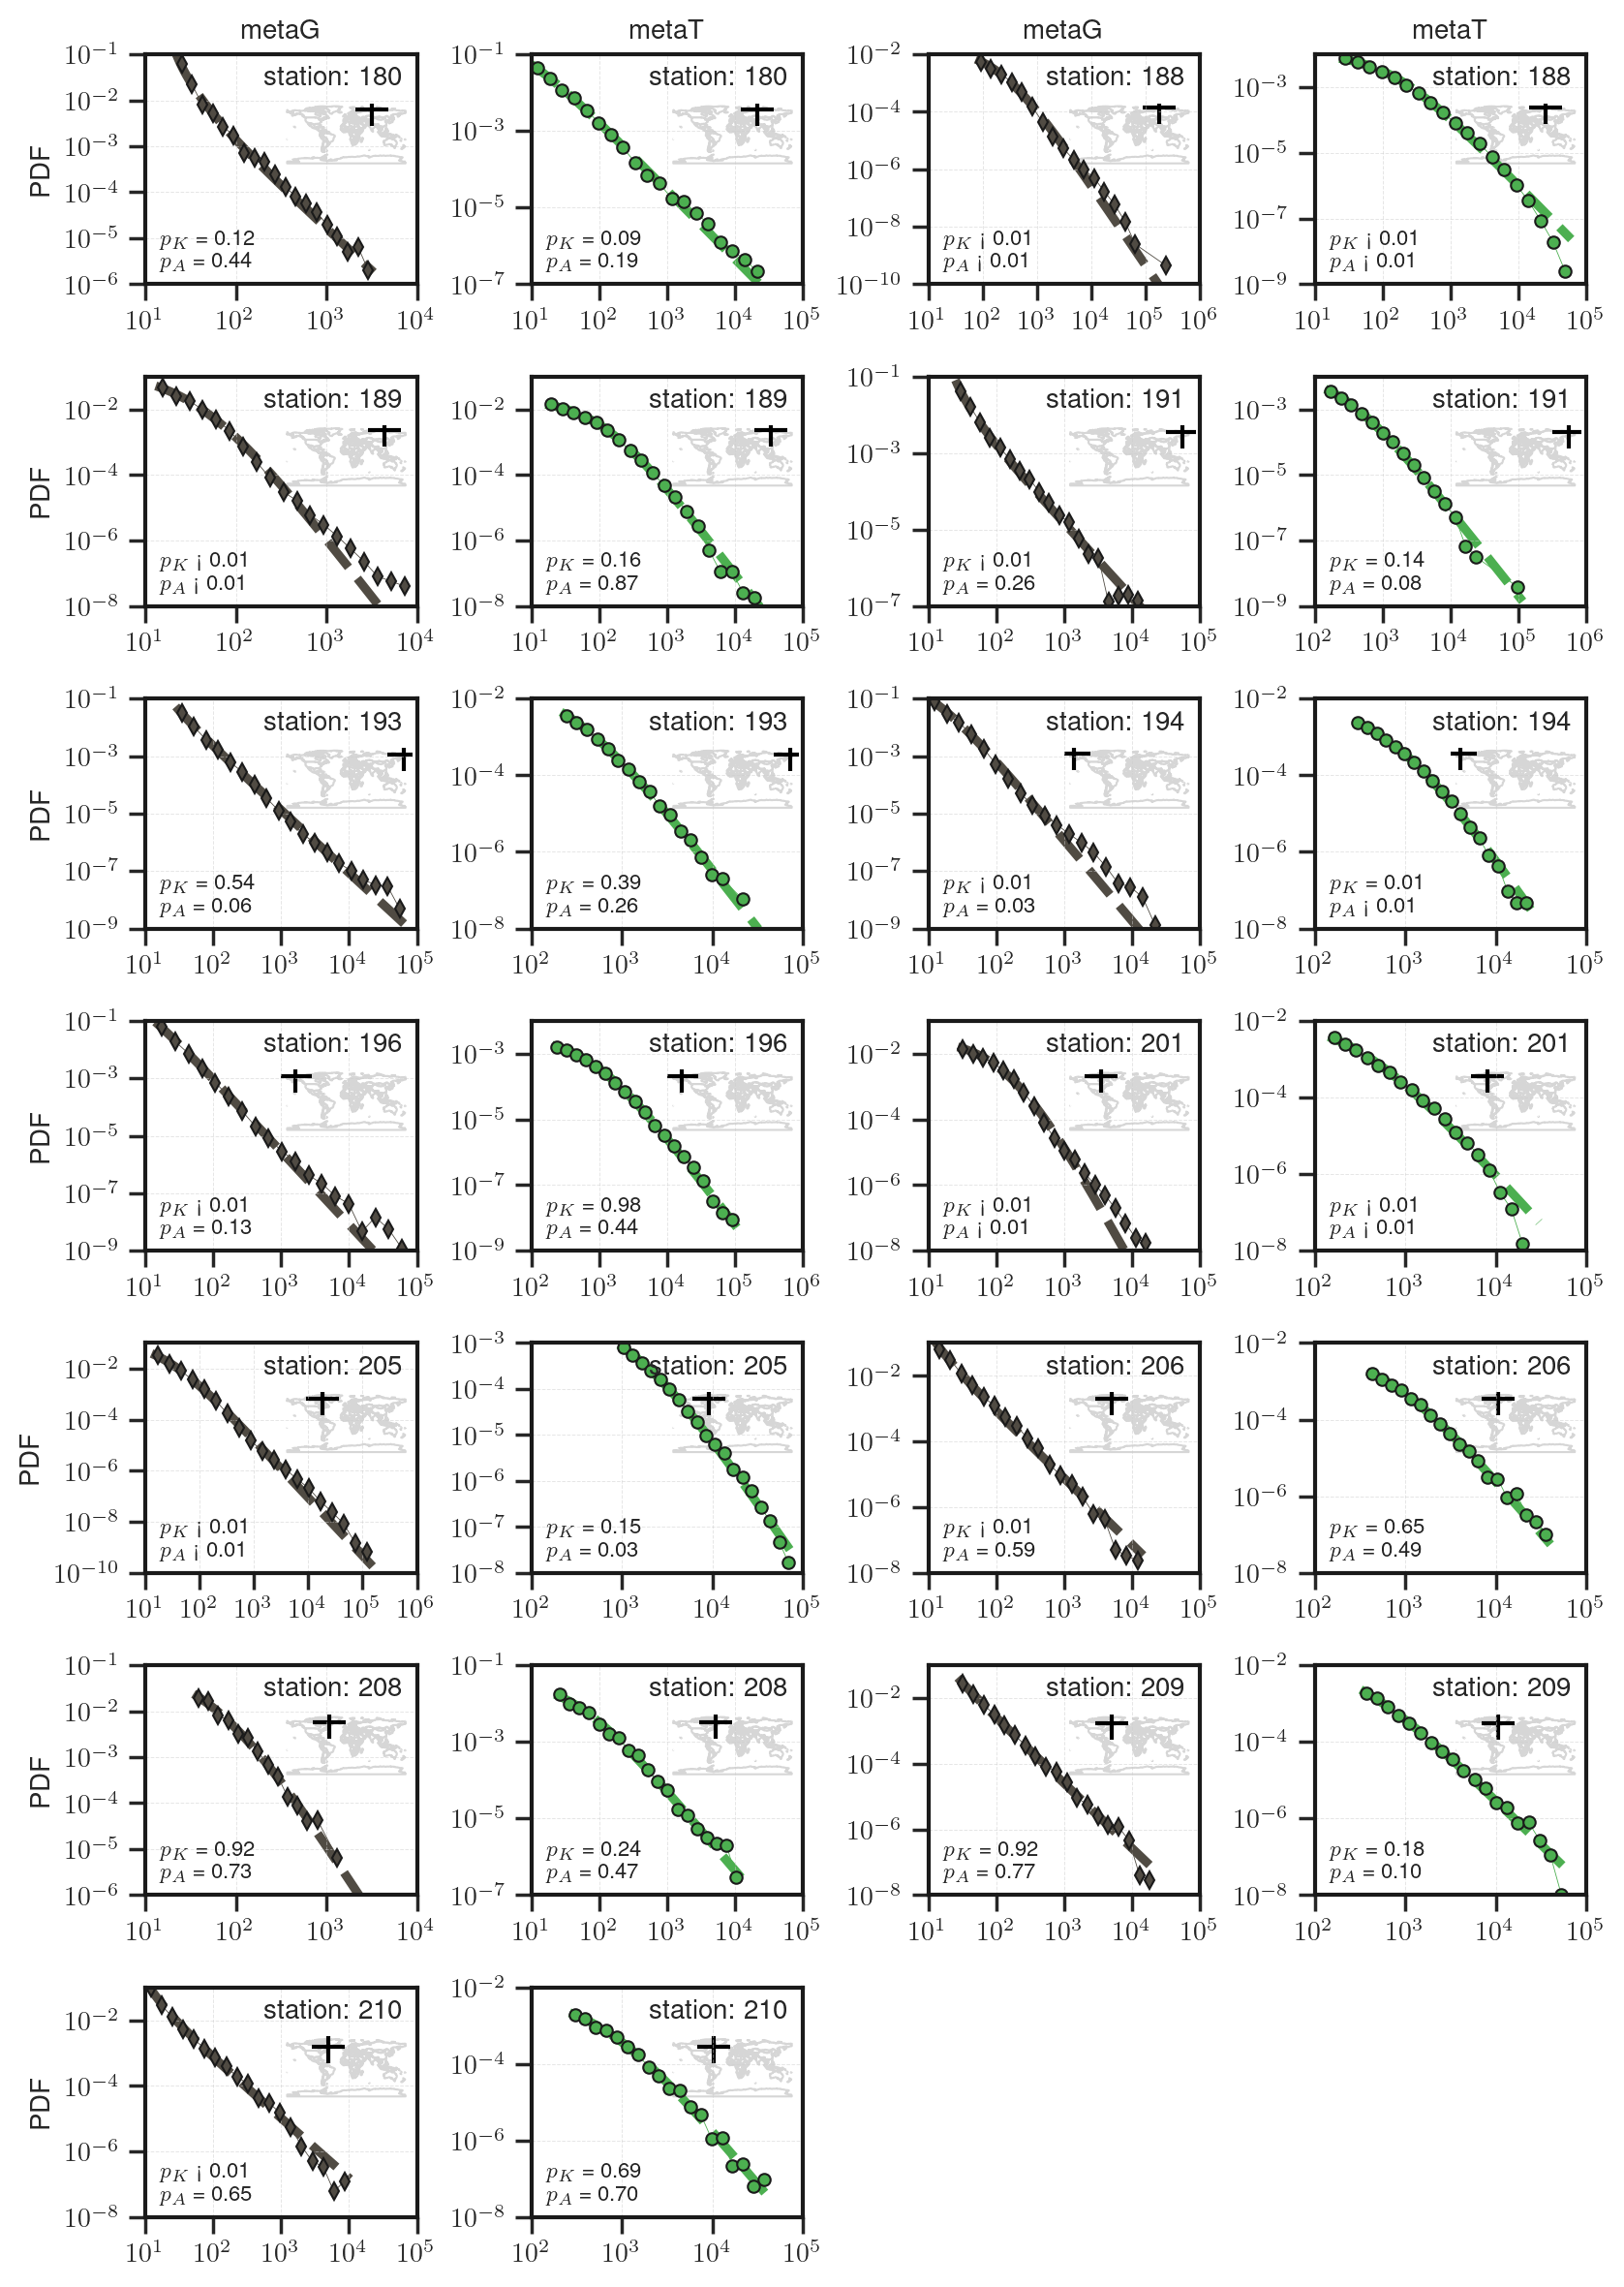

In [13]:
figsize=(8.27, 11.69)
labelsize=10
plt.rcParams['text.usetex'] = True

        
for i, station in enumerate(df_meta['metaT'].columns):
    if i % 16 == 0:
        if i < 16*4:
            fig, axes = plt.subplots(8, 4, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.1})
        else:
            fig, axes = plt.subplots(7, 4, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.1})
            # remove the last two axes
            axes[-1, -1].remove()
            axes[-1, -2].remove()

        for i_ax, ax in enumerate(axes.flatten()):
            # set font size of the axes to 12
            ax.tick_params(axis='both', which='major', labelsize=labelsize)
            ax.set_xscale('log')
            ax.set_yscale('log')
            if i_ax % 4 == 0:
                ax.set_ylabel('PDF', fontsize=labelsize)
            if i_ax >= 28:
                ax.set_xlabel('abundance', fontsize=labelsize)
            if i_ax < 4:
                if i_ax % 2 == 0:
                    ax.set_title('metaG', fontsize=labelsize)
                else:
                    ax.set_title('metaT', fontsize=labelsize)
            ax.grid(True, lw=0.35, ls='--', alpha=0.5)
            
            # ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
            # ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
            
            ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[], numticks=10))  # No minor ticks
            ax.xaxis.set_minor_formatter(NullFormatter())   

            # Customize grid
            ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
            ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
            ax.xaxis.set_major_formatter(LogFormatterMathtext())
            ax.yaxis.set_major_formatter(LogFormatterMathtext())
            
    for meta in ['metaT', 'metaG']:
        df = df_meta[meta]
        data = df[station]
        fit = df_fits[meta].loc[station]
        k, alpha, gamma, mu = 10**fit['logk'], fit['alpha'], 1, fit['mu_KS']
        data = data[~data.isna()]
        data = data[data>=mu]
        x, y = plot_logSAD(data, nbins=20)
        if meta == 'metaT':
            ax = axes.flatten()[(2*i)%32+1]
        else:
            ax = axes.flatten()[(2*i)%32]
        sns.lineplot(x=x, y=y, ax=ax, color=metacolor[meta], lw=0.3, marker=metamarker[meta], markersize=4.5, markeredgecolor='k')

        xlim_inf, xlim_sup = 10**np.floor(np.log10(data.min())), 10**np.ceil(np.log10(data.max()))
        ax.set_xlim(xlim_inf, xlim_sup)
        xticks = 10**np.arange(np.floor(np.log10(data.min())), np.ceil(np.log10(data.max()))+1, 1)
        ax.set_xticks(xticks)
        # remove minor xticks
        ylim_inf, ylim_sup = 10**np.floor(np.log10(y.min())), 10**np.ceil(np.log10(y.max()))
        ax.set_ylim(ylim_inf, ylim_sup)
        # if there are more than 5 decades, set the yticks every 2 decades
        if np.ceil(np.log10(y.max())) - np.floor(np.log10(y.min())) > 5:
            yticks = 10**np.arange(np.floor(np.log10(y.min())), np.ceil(np.log10(y.max()))+1, 2)
        else:
            yticks = 10**np.arange(np.floor(np.log10(y.min())), np.ceil(np.log10(y.max()))+1, 1)
        ax.set_yticks(yticks)
        
        
        x_plot = np.logspace(np.log10(1.00001*data.min()), np.log10(data.max()), 100)
        y_plot = [paretoDistribution(xx, k, alpha, gamma, mu) for xx in x_plot]
        sns.lineplot(x=x_plot, y=y_plot, ax=ax, color=metacolor[meta], lw=3.3, ls='--', zorder=0)
        text = 'station: ' + str(station)
        ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top', size=labelsize)
        #ax.set_title(station, fontsize=labelsize)
        
        pvalue_KS = fit['p_KS']
        pvalue_AD = fit['p_AD']
        if pvalue_KS >= 0.01:
            text = r"$p_K$ = {0:1.2f}".format(pvalue_KS)
        else:
            text = r"$p_K$ < 0.01"
        text += '\n'
        if pvalue_AD >= 0.01:
            text += r"$p_A$ = {0:1.2f}".format(pvalue_AD)
        else:  
            text += r"$p_A$ < 0.01"
        ax.text(0.05, 0.05, text, transform=ax.transAxes, ha='left', va='bottom', size=labelsize-2) 
        
        
        axg = ax.inset_axes([0.5, 0.45, 0.48, 0.4], zorder=-10)
        gpd.plotting.plot_dataframe(world, ax=axg, color='white', edgecolor='#d6d6d6', alpha=1., lw=.75)
        axg.scatter(metadata.loc[station, 'longitude'], metadata.loc[station, 'latitude'], marker='+', color='black', s=150, zorder=10)
        #title = r'#{0}: ({1:1.1f},{2:1.1f})'.format(station, metadata.loc[station, 'latitude'], metadata.loc[station, 'longitude'])
        #axg.set_title(title, fontsize=9)
        axg.set_axis_off()
        
    # if i == len(df_meta['metaT'].columns)-1:
    #     # remove empty axes
    #     # for i_ax in range(i_ax+1, 32):
    #     #     fig.delaxes(axes.flatten()[i_ax])
    #     fig.savefig('figures/thesis/SADs_all_{}.png'.format(i//16), dpi=300, bbox_inches='tight')
    #     plt.close(fig)
        
    # if i % 16 == 15:
    #     fig.savefig('figures/thesis/SADs_all_{}.png'.format(i//16), dpi=300, bbox_inches='tight')
    #     plt.close(fig)